# FusionSolarPy



A python client for the HuaweiFusionSolar API used to monitor solar power plants.
For use of this api there is thus no openAPI account needed, your normal credentials to log in to the web portal should work.
This client had 2 main goals: 
- being able to retreive realtime statistics and change parameters for use in Home Assistant -> see this integration: https://github.com/janmolemans/huawei_fusionsolar
- being able to retreive historical statistics for plotting and stuff

This client uses the https://region01eu5.fusionsolar.huawei.com end point by default. It is
possible to change this using the `huawei_subdomain` parameter. 

Please report any bugs!

This file is a markdown export of the readme.ipynb notebook.

```jupyter nbconvert readme.ipynb --to markdown```

# Install

`pip install huawei-fusionsolar`

# Example usage

In [11]:
from src.fusion_solar_py.client import FusionSolarClient
import json

## Create client

In [12]:
# log into the API - with proper credentials...
# Read YAML file
ROOT_DIR="."

import json

try:
    with open(f"{ROOT_DIR}/tests/credentials.json", 'r') as stream:
        cred = json.load(stream)
except FileNotFoundError:
    # fill in your credentials here
    cred= {
        "username": "FILL_IN",
        "password": "FILL_IN",
        "subdomain": "FILL_IN"
    }
    

client = FusionSolarClient(cred['username'], cred['password'], huawei_subdomain=cred['subdomain'])

## Plants

In [13]:
plants = client.get_plants()

In [14]:
for plant in plants:
    print(plant.name)
    # print(json.dumps(plant.get_plant_flow(), indent=4))
    # r= plant.get_plant_stats(return_resp=True)

steenhof huawei


## Devices

In [15]:
devices = client.get_devices()

### Query each device for latest metrics

In [16]:
units=set()
values=[]
for device in devices:
    for metric in device.get_device_stats().values():
        print(metric.name, metric.value, metric.unit)
        units.add(metric.unit)
        # values.append(metric.value)
        break # uncomment for more prints
    # print(device.name, device.type)
    # print(json.dumps(device.get_device_stats(), indent=4))
    # r= device.get_device_stats(return_resp=True)
    # break

PV energy yield power 0.000 kW
Inverter rated power 8.000 kW
Status Normal 
Charge/Discharge mode Maximum self-consumption 


### Plot historical metrics

In [19]:
import time
import datetime
import pandas
pandas.options.plotting.backend = "plotly"

d = datetime.datetime.now()
d = datetime.datetime(2022,9,1)
dt = datetime.datetime(
    year=d.year,
    month=d.month,
    day=d.day,
)
query_time= int(dt.timestamp())*1000

df=plants[0].get_plant_stats(query_time=query_time)


fig = df.plot()
# fig # uncomment for the interactive plotly figure

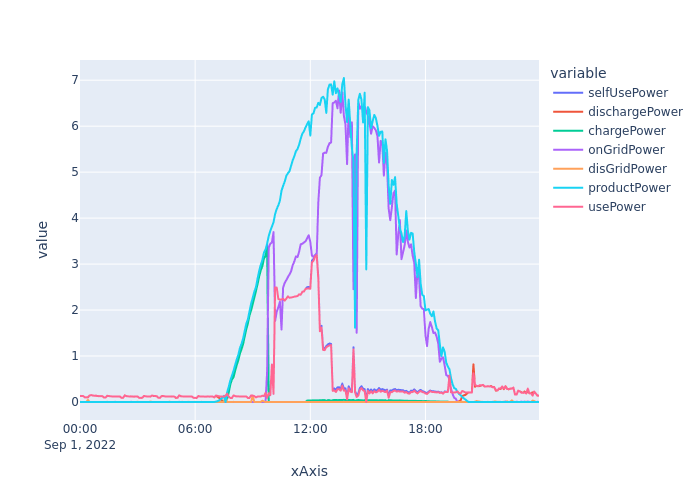

In [20]:
# save to static image for use in readme file

img_bytes = fig.to_image(format="png")
from IPython.display import Image
Image(img_bytes)